In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import skimage

import scipy.stats as st
from scipy.signal import find_peaks, peak_widths

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.graphics.mosaicplot import mosaic
from pathlib import Path

In [3]:
RANDOM_STATE = 26

# Predictive Maintenance (part 2) - Metro in Portugal

## 1. Data

### Description

The second data set contains real data of the metro trains in Porto, Portugal. Data is recorded in the period Jan-Jun 2022.

The dataset (1.7 GB) can be downloaded from [here](https://zenodo.org/record/6854240#.YvuPmHZBzBV) ([direct link](https://zenodo.org/record/6854240/files/dataset_train.csv?download=1)). Sections of the [paper](https://arxiv.org/abs/2207.05466) ([pdf](https://arxiv.org/pdf/2207.05466.pdf#view=fitH&toolbar=1)) are quoted below to understand the context:

>The Air Production Unit (APU) installed on the roof of Metro vehicles feeds units that perform different functions. One of these units is the secondary suspension, responsible for maintaining the height of the vehicle level regardless of the onboard number of passengers. 

> ...analog sensor signals (pressure, temperature, current consumption), digital signals (control signals, discrete signals), and GPS information (latitude, longitude, and speed).

>The main goal of the MetroPT dataset is to become a benchmark dataset for Predictive Maintenance. That is a real-world dataset, where the ground truth of anomalies is known from the company’s maintenance reports.

**Disclaimer**: It took my computer ~ 40 seconds to load the data. This was the cell that took the longest. Even though I experimented with several methods how to handle large data (reading pandas chunks, reading using dask, splitting into several csv files), in the end I decided that the standard way is easier and more practical.

### Paths

<div style="color:red">Note: The data set is not included in the project folders as it is too big. The default location is the desktop (see below).</div> 

In [4]:
DESKTOP = Path().home() / "Desktop"
INPUT_DATA = DESKTOP / "dataset_train.csv"
META_DATA = "data/metro_meta_data.xlsx"

### Schematic

Hydro-pneumatic schmatic of the Air Production Unit (APU) taken from the article.

<img src="images/2022-08-26 15_07_17.png">

### Columns

All original columns are listed below, a brief description is also added. This information is stored in an external excel file containing all meta data.

There are 3 types of data: 
- analogue (e.g. pressure)
- digital (e.g. valve activation flag)
- GPS

In [5]:
pd.options.display.max_colwidth = 200
features_meta_data = pd.read_excel(META_DATA, sheet_name = "features")
features_meta_data[["original_name", "variable_type", "description_short"]]

original_name variable_type  \
0         timestamp            na   
1               TP2      analogue   
2               TP3      analogue   
3                H1      analogue   
4       DV_pressure      analogue   
5        Reservoirs      analogue   
6   Oil_temperature      analogue   
7         Flowmeter      analogue   
8     Motor_current      analogue   
9              COMP       digital   
10       DV_eletric       digital   
11           Towers       digital   
12              MPG       digital   
13              LPS       digital   
14  Pressure_switch       digital   
15        Oil_level       digital   
16  Caudal_impulses       digital   
17          gpsLong      gps data   
18           gpsLat      gps data   
19         gpsSpeed      gps data   
20       gpsQuality      gps data   

                                                            description_short  
0                                                                   timestamp  
1                                                   compressor pressure [bar]  
2                                              pneumatic panel pressure [bar]  
3                                                         H1 valve activation  
4                             pressure drop when towers discharge water [bar]  
5                                                                     unknown  
6                                           temperature of the compressor oil  
7                                                                     unknown  
8   motor current [A] (compressor is: 0 = off, 4 = offloaded, 7 = under load)  
9                           compressor air intake valve (1 = no air going in)  
10                        compressor outlet valve (1 = compressor under load)  
11                                      active tower (0 = tower1, 1 = tower2)  
12                                              compressor start intake valve  
13                                threshold indicator (1 = pressure < 7 bars)  
14                                                                    unknown  
15                                     compressor oil level (1 = below level)  
16                                                                    unknown  
17                                                                   logitude  
18                                                                   latitude  
19                                          speed of the train [(guess) km/h]  
20                                   gps data quality (1 = corrupted, 0 = ok)

In [6]:
pd.options.display.max_colwidth = 50

### Failures

3 catastrophic failures were recorded during the 6 months of monitoring.

In [7]:
reported_failures = pd.read_excel(META_DATA, sheet_name = "failures")
reported_failures

id failure_type   component               start                 end
0   1    Air  Leak   Air Dryer 2022-02-28 21:53:00 2022-03-01 02:00:00
1   2    Air  Leak     Clients 2022-03-23 14:54:00 2022-03-23 15:24:00
2   3    Oil  Leak  Compressor 2022-05-30 12:00:00 2022-06-02 06:18:00

## 2. Clean and tidy

### Read

In [8]:
metro = pd.read_csv(INPUT_DATA)

### Get to know

In [9]:
metro.head(2)

timestamp    TP2    TP3    H1  DV_pressure  Reservoirs  \
0  2022-01-01 06:00:00 -0.012  9.758  9.76       -0.028       1.576   
1  2022-01-01 06:00:01 -0.012  9.760  9.76       -0.028       1.578   

   Oil_temperature  Flowmeter  Motor_current  COMP  ...  Towers  MPG  LPS  \
0            63.35  19.049625         3.9550     1  ...       1    1    0   
1            63.25  19.049625         4.0275     1  ...       1    1    0   

   Pressure_switch  Oil_level  Caudal_impulses  gpsLong   gpsLat  gpsSpeed  \
0                0          0                0 -8.65934  41.2124         0   
1                0          0                0 -8.65934  41.2124         0   

   gpsQuality  
0           1  
1           1  

[2 rows x 21 columns]

In [10]:
metro.shape

(10979546, 21)

In [11]:
metro.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'],
      dtype='object')

In [12]:
metro.dtypes

timestamp           object
TP2                float64
TP3                float64
H1                 float64
DV_pressure        float64
Reservoirs         float64
Oil_temperature    float64
Flowmeter          float64
Motor_current      float64
COMP                 int64
DV_eletric           int64
Towers               int64
MPG                  int64
LPS                  int64
Pressure_switch      int64
Oil_level            int64
Caudal_impulses      int64
gpsLong            float64
gpsLat             float64
gpsSpeed             int64
gpsQuality           int64
dtype: object

### Check for missing values

No values are missing.

In [13]:
metro.isna().sum()

timestamp          0
TP2                0
TP3                0
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Flowmeter          0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
Oil_level          0
Caudal_impulses    0
gpsLong            0
gpsLat             0
gpsSpeed           0
gpsQuality         0
dtype: int64

### Select columns

2 columns are removed because their meaning is unknown.

In [14]:
print("Dropped columns: ", features_meta_data[features_meta_data.keep == "no"].original_name.to_list())
print("Selected columns: ", features_meta_data[features_meta_data.keep == "yes"].original_name.to_list())

Dropped columns:  ['Pressure_switch', 'Caudal_impulses']
Selected columns:  ['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Oil_level', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']


In [15]:
columns_to_keep = features_meta_data[features_meta_data.keep == "yes"].original_name
metro = metro[columns_to_keep]

### Rename columns

New names for the remaining columns are loaded from the excel meta data file.

In [16]:
features_meta_data[features_meta_data.keep == "yes"][["original_name", "new_name", "description_short"]]

original_name                 new_name  \
0         timestamp                timestamp   
1               TP2      compressor_pressure   
2               TP3       pneumatic_pressure   
3                H1                 h1_valve   
4       DV_pressure              dv_pressure   
5        Reservoirs               reservoirs   
6   Oil_temperature          oil_temperature   
7         Flowmeter                     flow   
8     Motor_current            motor_current   
9              COMP  compressor_intake_valve   
10       DV_eletric  compressor_outlet_valve   
11           Towers                    tower   
12              MPG                      mpg   
13              LPS                      lps   
15        Oil_level                oil_level   
17          gpsLong                      lon   
18           gpsLat                      lat   
19         gpsSpeed                    speed   
20       gpsQuality                  quality   

                                    description_short  
0                                           timestamp  
1                           compressor pressure [bar]  
2                      pneumatic panel pressure [bar]  
3                                 H1 valve activation  
4     pressure drop when towers discharge water [bar]  
5                                             unknown  
6                   temperature of the compressor oil  
7                                             unknown  
8   motor current [A] (compressor is: 0 = off, 4 =...  
9   compressor air intake valve (1 = no air going in)  
10  compressor outlet valve (1 = compressor under ...  
11              active tower (0 = tower1, 1 = tower2)  
12                      compressor start intake valve  
13        threshold indicator (1 = pressure < 7 bars)  
15             compressor oil level (1 = below level)  
17                                           logitude  
18                                           latitude  
19                  speed of the train [(guess) km/h]  
20           gps data quality (1 = corrupted, 0 = ok)

In [17]:
new_names = features_meta_data[features_meta_data.keep == "yes"].new_name
new_names.name = ""
metro.columns = new_names

### Set index

In [18]:
metro.timestamp = pd.to_datetime(metro.timestamp)
metro = metro.set_index("timestamp")

In [19]:
start, end = metro.index[0], metro.index[-1]
print(f"Data is recorded in the period: {start} to {end}")

Data is recorded in the period: 2022-01-01 06:00:00 to 2022-06-02 15:49:53


## 3. Explore

### Create columns groups

Divide the columns in groups for easier filtering during EDA:
- `analogue_columns` = signal is continuous
- `digital_columns` = 1 or 0
- `gps_columns` = spatial data

In [20]:
used_columns = features_meta_data[features_meta_data.keep == "yes"]
columns_by_type = used_columns.groupby("variable_type")

analogue_columns = columns_by_type.get_group("analogue").new_name
digital_columns = columns_by_type.get_group("digital").new_name
gps_columns = columns_by_type.get_group("gps data").new_name
non_gps_columns = pd.concat([analogue_columns, digital_columns])

names = ["Analogue", "Digital", "GPS", "Non-GPS"]
groups = [analogue_columns, digital_columns, gps_columns, non_gps_columns]
for name, group in zip(names, groups):
    print(f"{name}: {group.values}\n")

Analogue: ['compressor_pressure' 'pneumatic_pressure' 'h1_valve' 'dv_pressure'
 'reservoirs' 'oil_temperature' 'flow' 'motor_current']

Digital: ['compressor_intake_valve' 'compressor_outlet_valve' 'tower' 'mpg' 'lps'
 'oil_level']

GPS: ['lon' 'lat' 'speed' 'quality']

Non-GPS: ['compressor_pressure' 'pneumatic_pressure' 'h1_valve' 'dv_pressure'
 'reservoirs' 'oil_temperature' 'flow' 'motor_current'
 'compressor_intake_valve' 'compressor_outlet_valve' 'tower' 'mpg' 'lps'
 'oil_level']



### Time series

#### Morning

Let's start by looking at a short interval during a normal working day (not after holidays or during the weekend). We want to understand the typical behavior of each signal.

Observations:
- Most signals are periodic, they have regular peaks or repeating shape.
- The patter might or might not be related to the metro stopping at different stations. This will be investigated in the next chapters.

In [21]:
def plot_timeseries_in_sequence(df, suptitle="", width=10, height=3):
    """
    Plot all columns of `df` below each other.
    `df` - df where each column is a time series
    `title` - plot title
    `width` and `height` - the dimensions of a single plot
    """
    n_plots = len(df.columns)
    fig, axs = plt.subplots(n_plots, figsize = (width, height * n_plots), sharex=True)
    fig.suptitle(suptitle, fontsize = 24)
    
    for column, ax in zip(df.columns, axs):
        ax.plot(df[column])
        ax.set_ylabel(column)
        ax.set_title(f"Time series for {column}")
    
    axs[-1].set_xlabel("Time")
    plt.show()   

In [22]:
def smooth_data(df, window=10):
    return df.rolling(window=window, center=True).mean()

In [23]:
morning = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 10:00')"
metro_morning = metro.query(morning)

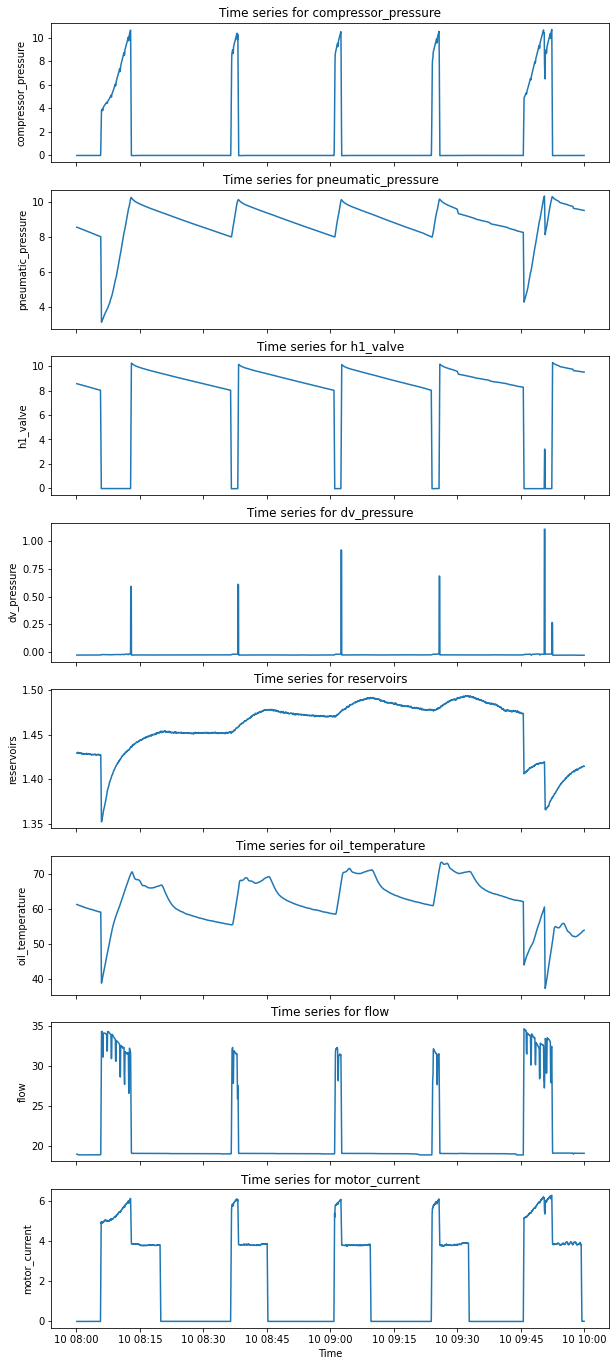

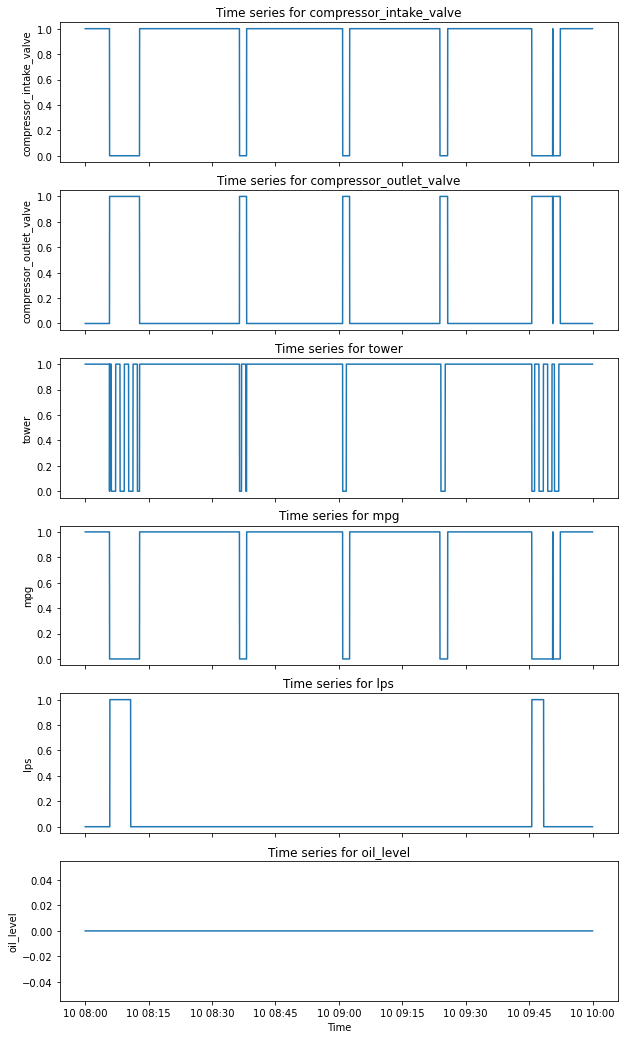

In [24]:
plot_timeseries_in_sequence(smooth_data(metro_morning[analogue_columns]))
plot_timeseries_in_sequence(metro_morning[digital_columns])

#### First failure

Description in the original article:
> Regarding the air leaks, the first one is provoked by a malfunction on the pneumatic pilot valve that opens the drain pipes during the operation of the compressor.

There are notable changes in the curves at about 23:00:
- `pneumatic_pressure` drops to 0.
- `lps` is triggered indicating the pressure is lower than 7 bars.
- `compressor_outlet_valve` becomes active and the `compressor_inlet_valve` - inactive. Both indicate that that the compressor is working. However, there is also no `motor_current` for ~2 hours.
- Finally, at around 06:00 the signals return to their usual patters. The article also states that the train recovered from the malfunction by itself.

In [25]:
reported_failures[reported_failures.id == 1]

id failure_type  component               start                 end
0   1    Air  Leak  Air Dryer 2022-02-28 21:53:00 2022-03-01 02:00:00

In [26]:
first_failure = "('2022-02-28 21:00' <= timestamp) & (timestamp <= '2022-03-01 08:00')"
metro_first_failure = metro.query(first_failure)

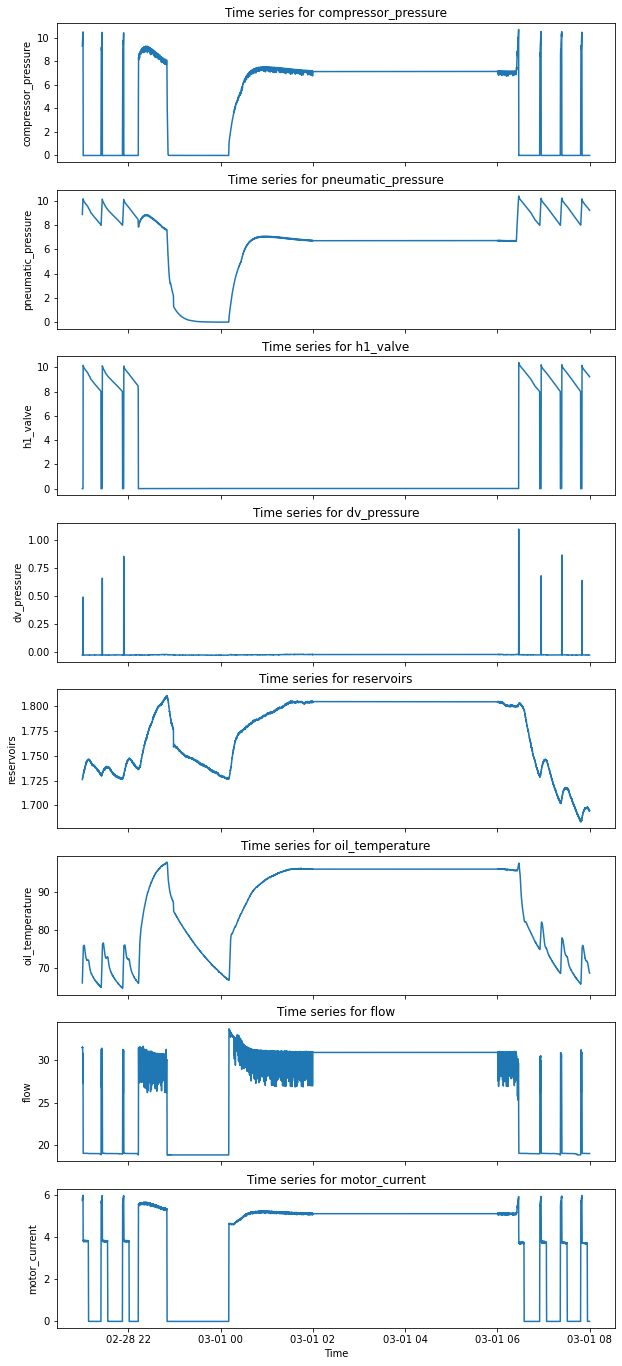

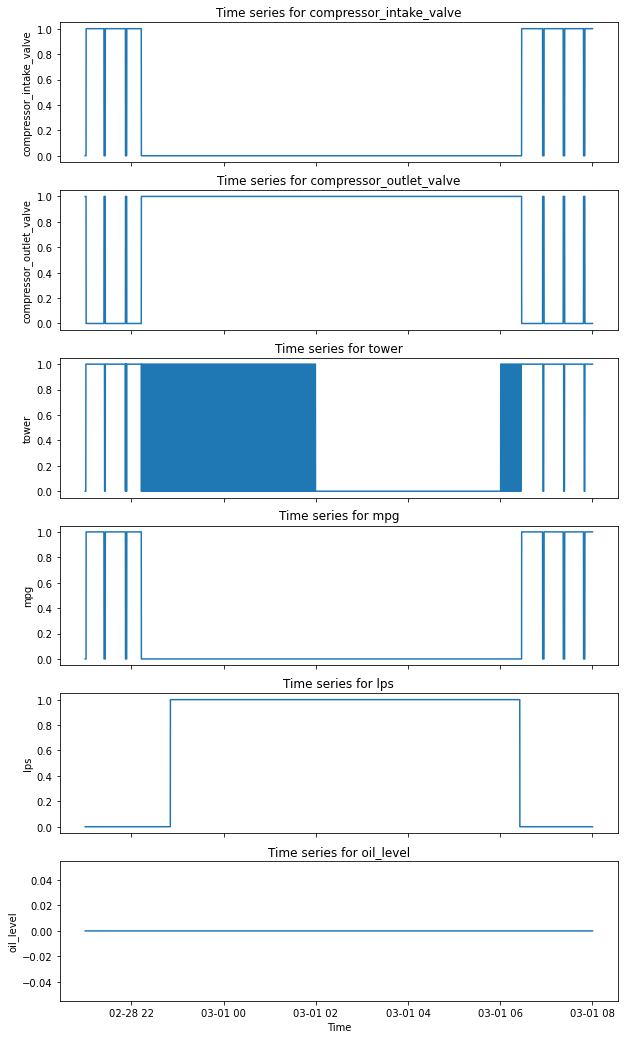

In [27]:
plot_timeseries_in_sequence(smooth_data(metro_first_failure[analogue_columns]))
plot_timeseries_in_sequence(metro_first_failure[digital_columns])

#### Second failure

The second failure is again caused by an air leak.

> The second problem was an air leak on a pipe that feeds several clients on the systems, such as breaks, suspension, etc. In the first case, the train recovered from the malfunction. In the second case, the train needed to move to the maintenance building.

In [28]:
reported_failures[reported_failures.id == 2]

id failure_type component               start                 end
1   2    Air  Leak   Clients 2022-03-23 14:54:00 2022-03-23 15:24:00

In [29]:
second_failure = "('2022-03-23 14:00' <= timestamp) & (timestamp <= '2022-03-23 16:00')"
metro_second_failure = metro.query(second_failure)

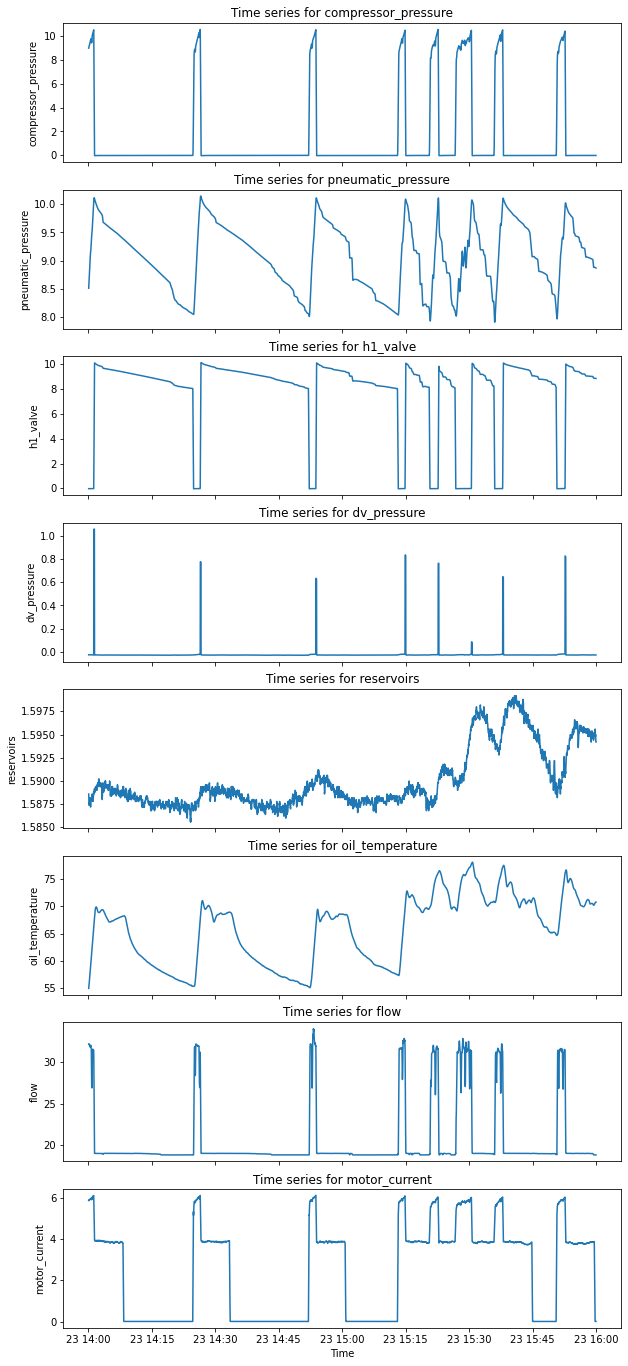

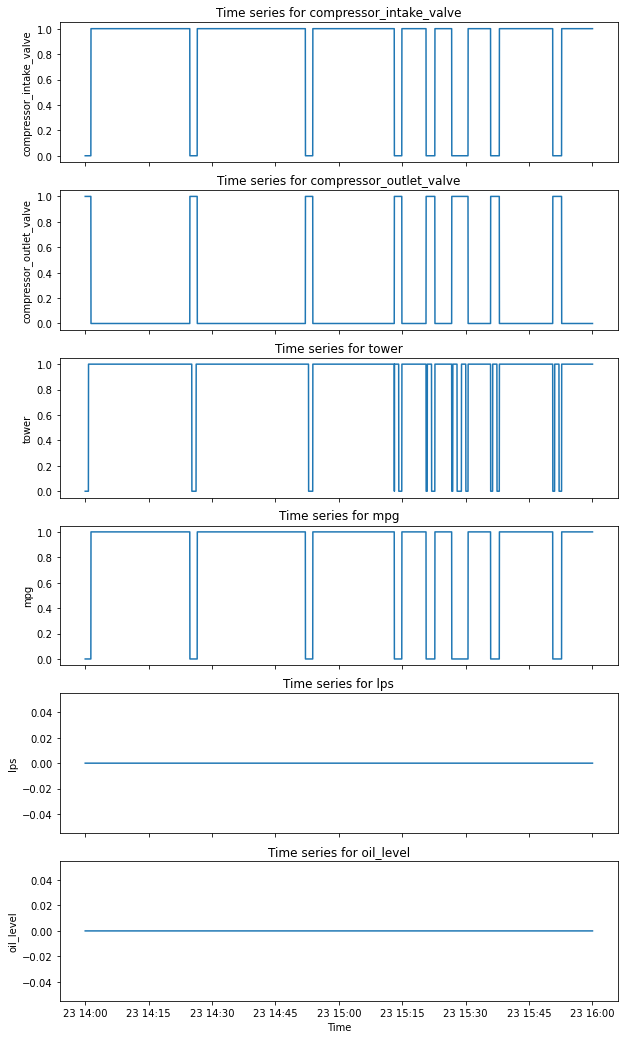

In [30]:
plot_timeseries_in_sequence(smooth_data(metro_second_failure[analogue_columns]))
plot_timeseries_in_sequence(metro_second_failure[digital_columns])

#### Third failure

The recorded duration for the third failure is much longer than the other two. The failure mode is also different - oil leak. The original description from the article is below: 

> Regarding the oil leak, due to hardware design, there was not any signal system related to oil to warn the train driver, the oil leak provoked severe damage to the engine of the compressor, and subsequentially, due to the inoperable compressor, it was observed a drop on the air pressure and the train needed to be removed from the tracks.

Observations:
- `lps` has one visible peak during the morning of 02 June indicating that the pressure dropped below 7 bar.
- No other patters are spotted.

In [31]:
reported_failures[reported_failures.id == 3]

id failure_type   component               start                 end
2   3    Oil  Leak  Compressor 2022-05-30 12:00:00 2022-06-02 06:18:00

In [32]:
third_failure = "('2022-05-30 12:00' <= timestamp) & (timestamp <= '2022-06-02 10:00')"
metro_third_failure = metro.query(third_failure)

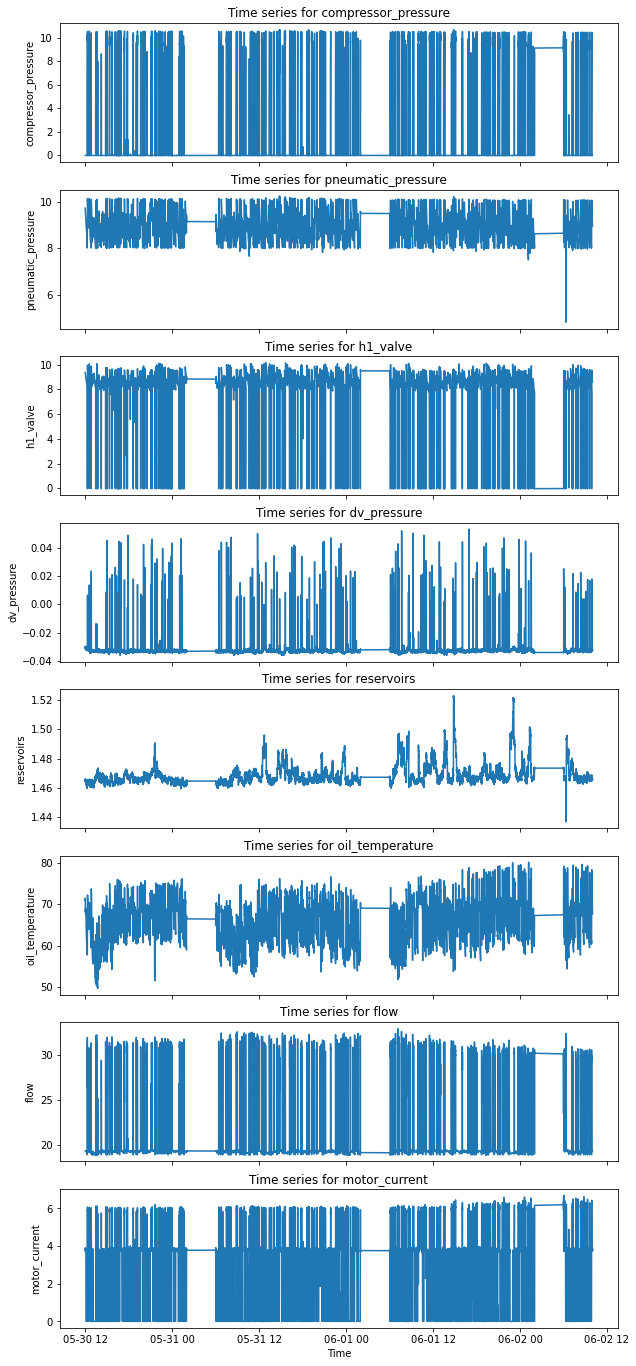

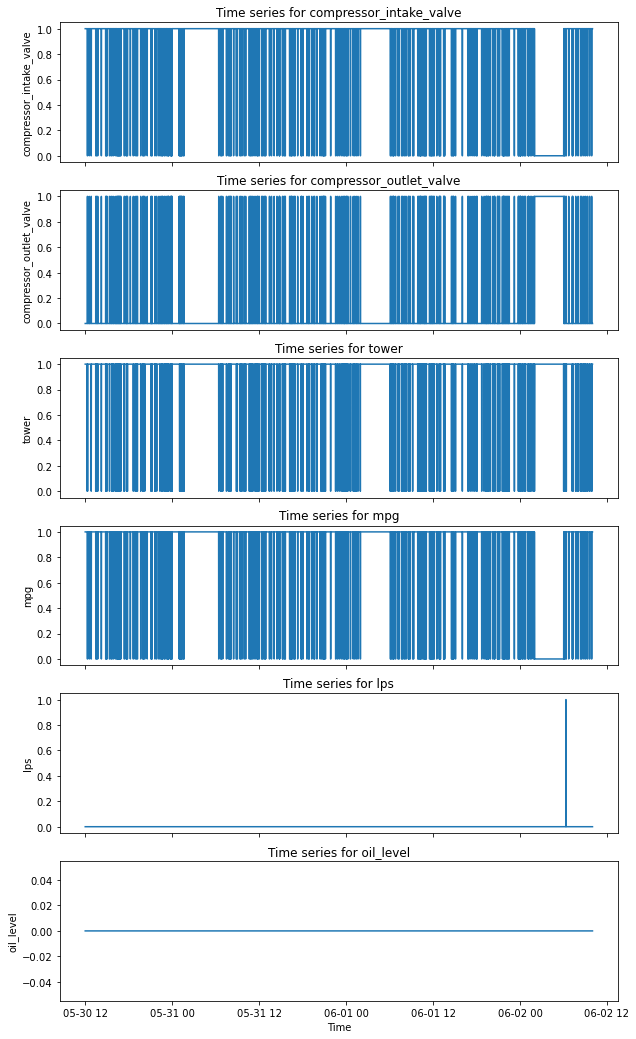

In [33]:
plot_timeseries_in_sequence(smooth_data(metro_third_failure[analogue_columns]))
plot_timeseries_in_sequence(metro_third_failure[digital_columns])

### Geographic data

#### Train speed

Let's first plot the train speed for the same typical working-day morning as we did in the time series analysis. We shall use only valid (not corrupted) data so we should filter `quality == 1`.

We will use the `plotly express` library as its interactivity (=ability to zoom in, move around, and see locations) is quite helpful in our case.

Observations:
- The route matches the [map](https://en.metrodoporto.pt/metrodoporto/uploads/document/file/371/MAPA_DE_REDE_2019.pdf) of the metro system, more specifically lines A (blue), E (purple), and F (orange).
- The color of the dots (line) indicates the train `speed`. The speed is alternating between intervals where it is high and then almost 0. Reasonable explanation is that there are stations at the 0-speed locations. This will be our next analysis.

In [34]:
start = "2022-01-10 08:00"
end = "2022-01-10 12:00"
query = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
gps_data = metro[gps_columns].query(query)

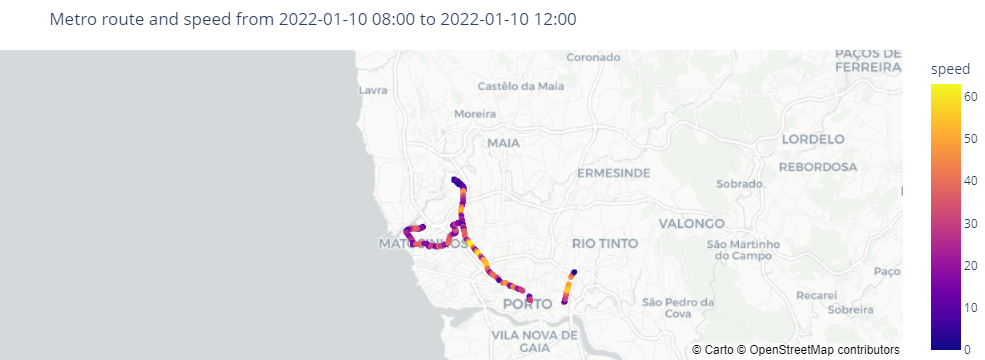

In [35]:
fig = px.scatter_mapbox(
    gps_data, 
    lat="lat", 
    lon="lon", 
    color = "speed", 
    zoom=10, 
    title=f"Metro route and speed from {start} to {end}",
)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

[Map](https://en.metrodoporto.pt/metrodoporto/uploads/document/file/371/MAPA_DE_REDE_2019.pdf) of the metro system:
<img src="images/2022-08-31 10_25_26.png">

#### Stations

I could not find the values of the coordinates for [Porto's 81 stations](https://www.introducingporto.com/metro). Therefore, I extracted some of the station locations manually; the records are in the meta data file.

In [36]:
stations = pd.read_excel(META_DATA, sheet_name = "stations")
stations

station        lat       lon
0        Casa da Música  41.160787 -8.628263
1               Francos  41.166533 -8.636390
2  Senhor de Matosinhos  41.188205 -8.685120
3       Senhora da Hora  41.188119 -8.654463
4              Esposade  41.216089 -8.654543
5             Aeroporto  41.237109 -8.669468
6              Contumil  41.165711 -8.578632

#### Train speed and stations

Observations:
- Locations where the train speed is low coincide with the station locations.

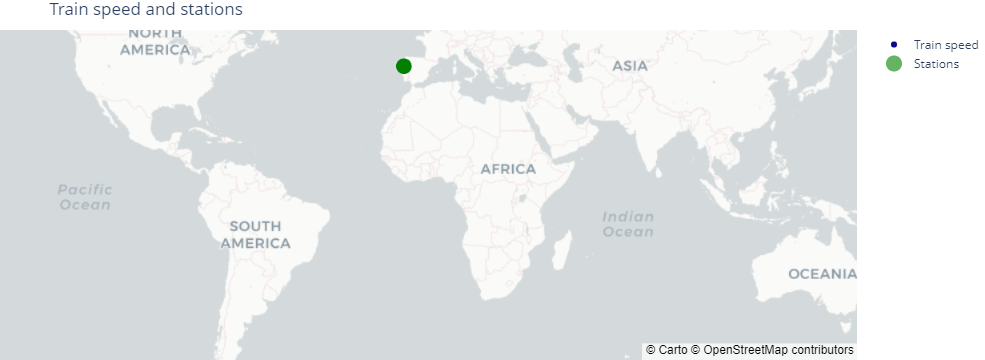

In [37]:
fig = go.Figure()

fig.add_trace(
    go.Scattermapbox(
        lat=gps_data.lat,
        lon=gps_data.lon,
        marker = go.scattermapbox.Marker(color = gps_data.speed),
        name = "Train speed",
    )
)

fig.add_trace(
    go.Scattermapbox(
        lat=stations.lat,
        lon=stations.lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=16,
            color='green',
            opacity=0.6,
            ),
        text=stations.station,
        name = "Stations",
    )
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":30,"l":0,"b":0},
    title="Train speed and stations",
    
)
fig.show()

#### Failure locations

Next, lets find where on the line the failure occurred. We will used narrower time intervals based on the abnormalities in the sensor readings observed above. The third failure is omitted since:
- there is no valid GPS data in the failure period
- the time of occurrence can't be determined as the reported duration is much longer than the other two (2 days vs 1-2 hours)

Observations: no relationship.

In [38]:
first_airleak = "('2022-02-28 22:00' <= timestamp) & (timestamp <= '2022-03-01 01:00') & (quality == 1)"
metro_first_airleak = metro.query(first_airleak)

second_airleak = "('2022-03-23 14:54' <= timestamp) & (timestamp <= '2022-03-23 15:24') & (quality == 1)"
metro_second_airleak = metro.query(second_airleak)

for metro_airleak in [metro_first_airleak, metro_second_airleak]:
    print(metro_airleak.shape)

(10801, 18)
(1801, 18)


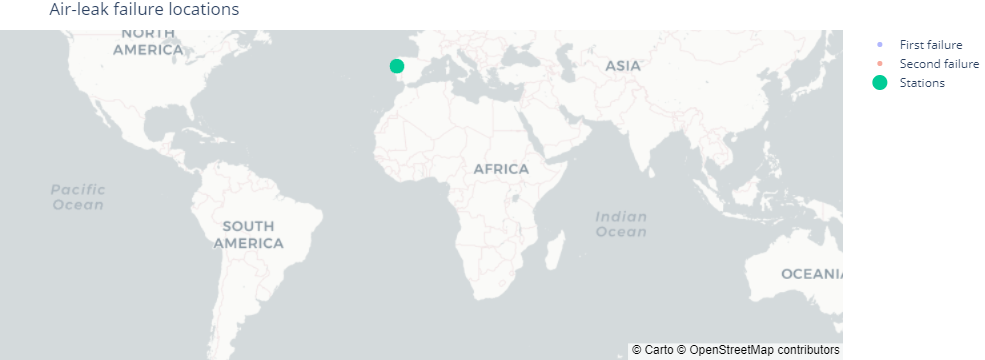

In [39]:
fig = go.Figure()

# Failures
for breakdown, label in zip([metro_first_airleak, metro_second_airleak], ['First failure', 'Second failure']):
    fig.add_trace(
        go.Scattermapbox(
            lat=breakdown.lat,
            lon=breakdown.lon,
            opacity=0.5,
            marker={"size": 5,},
            name=label,
        )
    )

# Stations
fig.add_trace(
    go.Scattermapbox(
        lat=stations.lat,
        lon=stations.lon,
        marker={
            "size": 15,
        },
        text = stations.station,
        name = "Stations"
    )
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":30,"l":0,"b":0},
    title="Air-leak failure locations"
)
fig.show()

#### GPS data quality

Check of the GPS data quality.

Observations:
- Most GPS data after 01 April is corrupted. Root cause in unknown.

In [40]:
interval_gps_quality_check = "('2022-02-10 01:00' <= timestamp) & (timestamp <= '2022-06-02 06:00')"
metro_gps_quality_check = metro.query(interval_gps_quality_check)

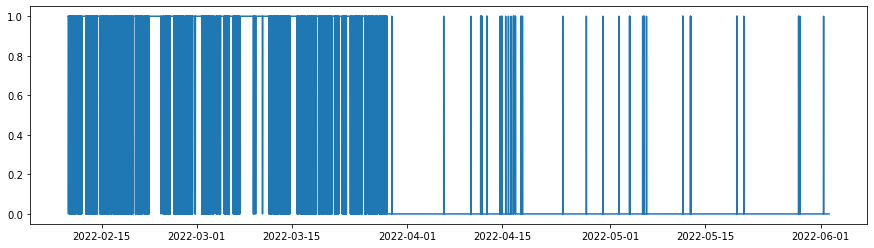

In [41]:
plt.figure(figsize=(15, 4))
plt.plot(metro_gps_quality_check.quality)
plt.show()

### Signal peaks 

#### Detect

One other piece of information we can extract from the data is the peaks location. Steps:
1. Filter data for a short period and with proper GPS quality.
2. Select one analogue sensor signal. Find its peaks.
3. Plot to validate result.

We can use `scipy.signal.find_peaks()` and play with its arguments to detect the peaks.
`compressor_pressure` is chosen to test the algorithm.

Conclusion: we can detect peaks in the data.

Future work:
- Investigate how this can be helpful. For example, count the valve activations if this is an indication of its lifetime. Need some knowledge in the hydraulic domain first.
- Investigate other methods to work with signals.
- Investigate the `scipy.signal` library.

In [42]:
start = "2022-01-10 08:00"
end = "2022-01-10 12:00"
interval_peaks = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
metro_peaks = metro.query(interval_peaks)

In [43]:
signal = metro_peaks.compressor_pressure
peak_indeces, _ = find_peaks(signal, height=10, distance=300)
peaks = signal.iloc[peak_indeces].copy()

print(f"Peaks found: {len(peaks)}")

Peaks found: 11


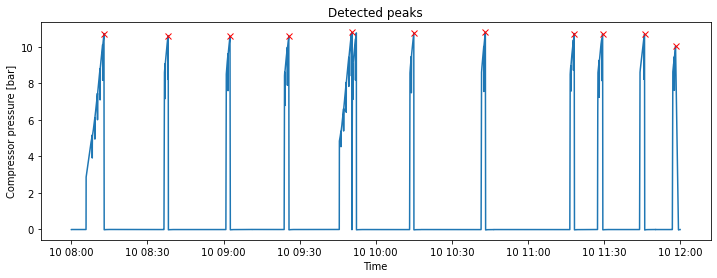

In [44]:
plt.figure(figsize = (12, 4))
plt.plot(signal)
plt.plot(peaks, "rx")

plt.title("Detected peaks")
plt.xlabel("Time")
plt.ylabel("Compressor pressure [bar]")
plt.show()

In [45]:
# # Interactive version of the plot above using plotly express

# fig1 = px.line(signal)
# fig2 = px.scatter(peaks, color_discrete_sequence=['#ff7f0e'])
# fig3 = go.Figure(data=fig1.data + fig2.data)
# fig3.show()

#### Compare to stations

Let's check the hypothesis that the peak locations match the station locations. This seems logical as the Air Production Unit supplies the suspension system and people get off and on at stations changing the load on the suspension.

Procedure:
Firstly, we detect the peaks for a longer period, say 1 day. Then, we combine the locations to the available station locations. Finally, we plot and look for matches.

Observations:
- The plotted stations are too few (7 out of 81). The rest must be obtained to make a solid conclusion (e.g. by web scraping from google maps).
- There is only one match (Casa da Música).

In [46]:
start = "2022-01-10 08:00"
end = "2022-01-11 08:00"
interval_many_peaks = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
metro_many_peaks = metro.query(interval_many_peaks)

In [47]:
signal = metro_many_peaks.compressor_pressure
peak_indeces, _ = find_peaks(signal, height=10, distance=300)
peaks = signal.iloc[peak_indeces].copy()

print(f"Peaks found: {len(peaks)}")

Peaks found: 49


In [48]:
peaks_gps_data = metro_peaks[metro_peaks.index.isin(peaks.index)][["lon", "lat"]]

stations_and_peaks = pd.concat([stations, peaks_gps_data], keys=["station", "peak"])
stations_and_peaks = stations_and_peaks.reset_index()
stations_and_peaks = stations_and_peaks.drop(columns=["level_1"])
stations_and_peaks = stations_and_peaks.rename(columns={"level_0": "location_type"})

stations_and_peaks.sample(n=5, random_state = RANDOM_STATE)

location_type station      lat      lon
12          peak     NaN  41.2090 -8.65473
14          peak     NaN  41.1874 -8.69353
9           peak     NaN  41.2133 -8.66083
11          peak     NaN  41.2118 -8.65880
8           peak     NaN  41.2132 -8.66088

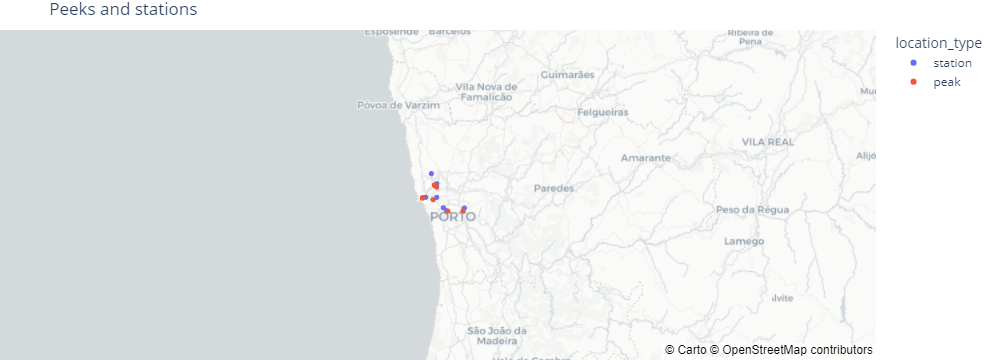

In [49]:
fig = px.scatter_mapbox(
    data_frame = stations_and_peaks,
    lat="lat",
    lon="lon",
    color="location_type",
    hover_name="station"
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":30,"l":0,"b":0},
    title="Peeks and stations"
)
fig.show()

#### Width

Finally, let's look at another parameter of the peaks - their widths. We can maybe estimate the [Remaining Useful Life (RUL)](https://www.mathworks.com/content/dam/mathworks/ebook/estimating-remaining-useful-life-ebook.pdf) based on the current lifetime (but first - a discussion with a hydraulics expert to understand what makes sense).

We use `scipy.signal.peak_widths()`, it returns `tuple(width, y, x_start, x_end)`.

In [50]:
start = "2022-01-10 08:00"
end = "2022-01-10 10:00"
interval_peaks = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
metro_peaks = metro.query(interval_peaks)

In [51]:
signal = metro_peaks.compressor_pressure
peak_indeces, _ = find_peaks(signal, height=10, distance=300)
peaks = signal.iloc[peak_indeces].copy()

print(f"Peaks found: {len(peaks)}")

Peaks found: 5


In [52]:
widths = peak_widths(signal.values, peak_indeces, rel_height=0.95)
widths

(array([314.70394602, 102.40511324,  99.41946394, 111.15023767,
        298.80789441]),
 array([0.5272, 0.5097, 0.5067, 0.5075, 0.5153]),
 array([ 347.22960526, 2078.5925    , 3543.28430851, 4921.89496528,
        6225.10815353]),
 array([ 661.93355129, 2180.99761324, 3642.70377246, 5033.04520295,
        6523.91604793]))

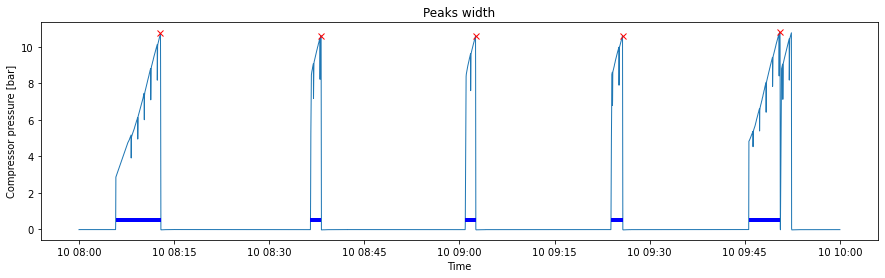

In [53]:
plt.figure(figsize = (15, 4))

# Signal
plt.plot(signal, linewidth = 1)

# Peaks
plt.plot(peaks, "rx")

# Widths
xmin = signal.index[widths[2].astype(int)]
xmax = signal.index[widths[3].astype(int)]
plt.hlines(y = widths[1], xmin = xmin, xmax = xmax, color="blue", linewidth = 4)

plt.title("Peaks width")
plt.xlabel("Time")
plt.ylabel("Compressor pressure [bar]")
plt.show()

## 4. Future work

In my opinion, the best improvements to the analysis above would be to:
- understand the hydro-pneumatic system in depth and come up with new features (domain knowledge, feature engineering)
- get better insights from the current time series 
- apply predictive models typical for this kind of analysis
- use models suitable for low number of failures (classes)


The authors themselves ([paper](https://arxiv.org/pdf/2207.05466)) identify two primary purposes of the dataset:
1) Predicting failures (the start and the duration). Goal: minimize the number of false positives and false negatives. Requirement by the metro company: detect the failure at least two hours before the train becomes non-operational.
2) Identifying the components involved in the failure.


Practical ideas:
- Create a new column with the type of the location: "during traveling" or when "at station". Do this by checking if a set of coordinates is inside the station vicinity (e.g. a circle with specific radius).
- Compare data for the same location (e.g. station) but in different days.

## 5. References

Articles and papers I came across during the research:
- [Fault diagnosis for the Space Shuttle main engine](https://www.researchgate.net/publication/23618683_Fault_diagnosis_for_the_Space_Shuttle_main_engine)
- [AI-Automated Hard-Hat Detection](https://assets-global.website-files.com/618cdeef45d18e4ef2fd85f3/621cef628758fd1c35be832b_AI-Automated-Hard-Hat-Detection.pdf)
- [Machine learning algorithm predicts how to get the most out of electric vehicle batteries
](https://www.cam.ac.uk/research/news/machine-learning-algorithm-predicts-how-to-get-the-most-out-of-electric-vehicle-batteries)
- ! [Machine Learning Application in the Manufacturing Industry](https://mobidev.biz/blog/machine-learning-application-use-cases-manufacturing-industry)
- [Using Python and Selenium to get coordinates from street addresses](https://towardsdatascience.com/using-python-and-selenium-to-get-coordinates-from-street-addresses-62706b6ac250)
- [Smoothing time series in Pandas](https://www.mikulskibartosz.name/smoothing-time-series-in-pandas/)

Videos:
- [AI Inspection: Machine Learning / Computer Vision for Visual Defect Detection](https://youtu.be/UY6xbrcViVw)

### Quotes

From [here](https://mobidev.biz/blog/machine-learning-application-use-cases-manufacturing-industry):
> ML MODELS USED FOR PREDICTIVE MAINTENANCE
> - Regression Models: these predict the Remaining Useful Life (RUL) of the equipment. This uses historical and static data and allows manufacturers to see how many days are left until the machine experiences a failure.
> - Classification Models: these models predict failures within a predefined time span.
> - Anomaly Detection Models: These flag devices upon detecting abnormal system behavior.